In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import spacy
from scipy.sparse import hstack, csr_matrix

In [10]:
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [12]:
df = pd.read_csv("LiarDataset.csv")

In [14]:
df.shape

(10240, 15)

In [16]:
df.head(10)

,id,label,statement,subject,speaker,speakers_job,state_info,party_aff,bt_cnt,f_cnt,ht_cnt,mt_cnt,pf_cnt,context,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,"But Vos specifically used the word ""fired,"" wh..."
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.,But determining that would take significant de...
7,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.","However, it was not that bill, but another one..."
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website,But Johnson is correct that many other factors...
9,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video,Considering that the $532 million figure cover...


In [342]:
df.isnull().sum()

id                  0
label               0
statement           0
subject             2
speaker             2
speakers_job     2898
state_info       2210
party_aff           2
bt_cnt              2
f_cnt               2
ht_cnt              2
mt_cnt              2
pf_cnt              2
context           102
justification      84
dtype: int64

In [343]:
df = df[['label', 'statement', 'bt_cnt', 'f_cnt', 'ht_cnt', 'mt_cnt', 'pf_cnt']]
df.columns = ['label', 'statement', 'barely-true_count', 'false_count', 'half-true_count', 'mostly-true_count', 'pants-fire_count']
df.head()

,label,statement,barely-true_count,false_count,half-true_count,mostly-true_count,pants-fire_count
0,false,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0
1,half-true,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0
3,false,Health care reform legislation is likely to ma...,7.0,19.0,3.0,5.0,44.0
4,half-true,The economic turnaround started at the end of ...,15.0,9.0,20.0,19.0,2.0


In [344]:
df = df.dropna(subset=['label', 'statement', 'barely-true_count', 'false_count', 'half-true_count', 'mostly-true_count', 'pants-fire_count'])
df.head(10)

,label,statement,barely-true_count,false_count,half-true_count,mostly-true_count,pants-fire_count
0,false,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0
1,half-true,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0
3,false,Health care reform legislation is likely to ma...,7.0,19.0,3.0,5.0,44.0
4,half-true,The economic turnaround started at the end of ...,15.0,9.0,20.0,19.0,2.0
5,true,The Chicago Bears have had more starting quart...,0.0,3.0,2.0,5.0,1.0
6,barely-true,Jim Dunnam has not lived in the district he re...,3.0,1.0,1.0,3.0,1.0
7,half-true,I'm the only person on this stage who has work...,70.0,71.0,160.0,163.0,9.0
8,half-true,"However, it took $19.5 million in Oregon Lotte...",0.0,0.0,1.0,0.0,1.0
9,mostly-true,Says GOP primary opponents Glenn Grothman and ...,0.0,0.0,0.0,1.0,0.0


In [345]:
df.isnull().sum()

label                0
statement            0
barely-true_count    0
false_count          0
half-true_count      0
mostly-true_count    0
pants-fire_count     0
dtype: int64

In [346]:
print(df['label'].unique())

['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


In [347]:
df['label'] = df['label'].map({
    'true': 1,  
    'false': 0,  
    'barely-true': 0,  
    'half-true': 1,  
    'mostly-true': 1,  
    'pants-fire': 0  
})

df.head(10)

,label,statement,barely-true_count,false_count,half-true_count,mostly-true_count,pants-fire_count
0,0,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0
1,1,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0
2,1,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0
3,0,Health care reform legislation is likely to ma...,7.0,19.0,3.0,5.0,44.0
4,1,The economic turnaround started at the end of ...,15.0,9.0,20.0,19.0,2.0
5,1,The Chicago Bears have had more starting quart...,0.0,3.0,2.0,5.0,1.0
6,0,Jim Dunnam has not lived in the district he re...,3.0,1.0,1.0,3.0,1.0
7,1,I'm the only person on this stage who has work...,70.0,71.0,160.0,163.0,9.0
8,1,"However, it took $19.5 million in Oregon Lotte...",0.0,0.0,1.0,0.0,1.0
9,1,Says GOP primary opponents Glenn Grothman and ...,0.0,0.0,0.0,1.0,0.0


In [348]:
correlation_matrix = df[['barely-true_count', 'false_count', 'half-true_count', 'mostly-true_count', 'pants-fire_count']].corr(method='pearson')


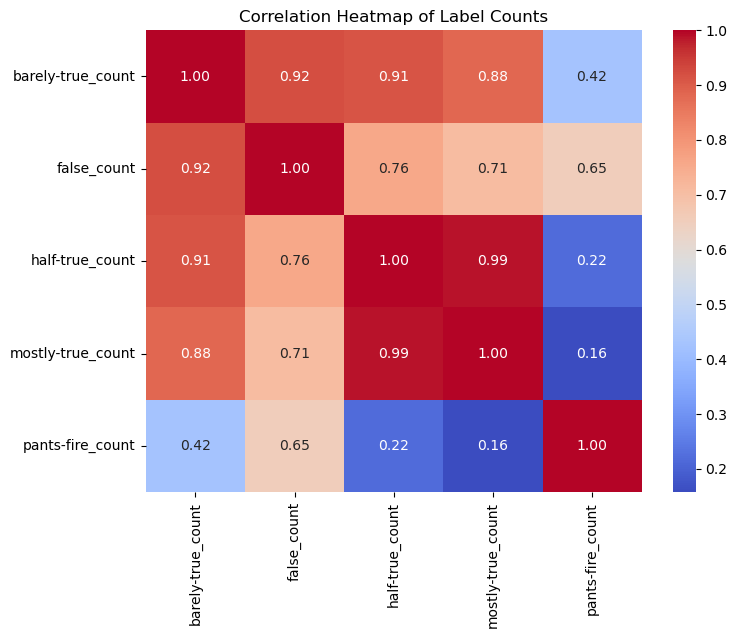

In [349]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Label Counts")
plt.show()

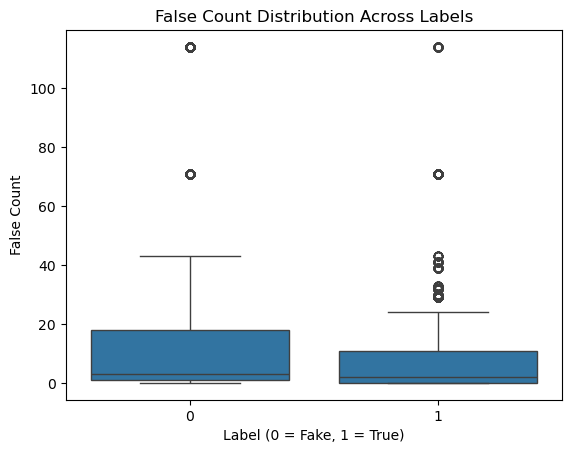

In [350]:
sns.boxplot(x='label', y='false_count', data=df)
plt.title("False Count Distribution Across Labels")
plt.xlabel("Label (0 = Fake, 1 = True)")
plt.ylabel("False Count")
plt.show()

In [351]:
df['false_count'] = df['false_count'].clip(upper=30)

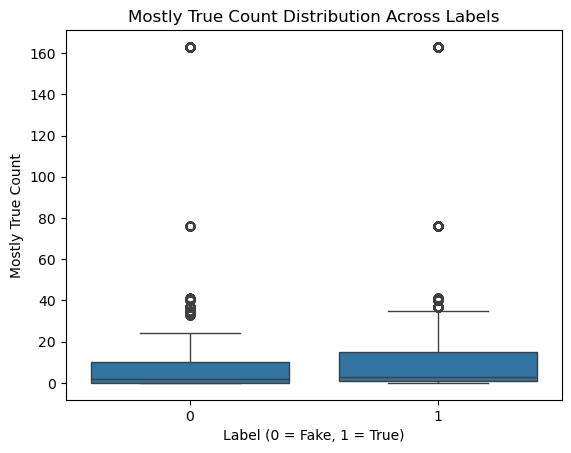

In [352]:
sns.boxplot(x='label', y='mostly-true_count', data=df)
plt.title("Mostly True Count Distribution Across Labels")
plt.xlabel("Label (0 = Fake, 1 = True)")
plt.ylabel("Mostly True Count")
plt.show()

In [353]:
df['mostly-true_count'] = df['mostly-true_count'].clip(upper=30)

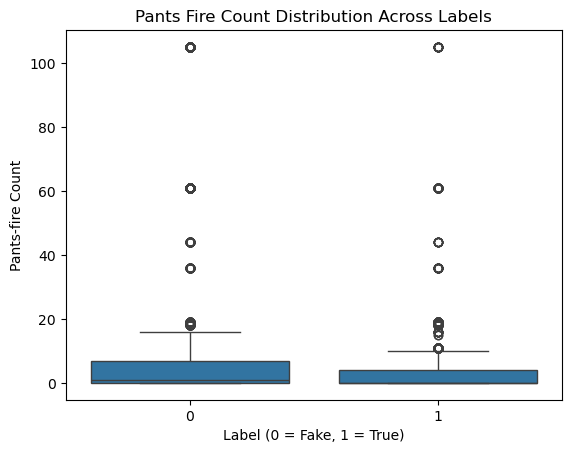

In [354]:
sns.boxplot(x='label', y='pants-fire_count', data=df)
plt.title("Pants Fire Count Distribution Across Labels")
plt.xlabel("Label (0 = Fake, 1 = True)")
plt.ylabel("Pants-fire Count")
plt.show()

In [355]:
df['pants-fire_count'] = df['pants-fire_count'].clip(upper=10)

label
1    5752
0    4486
Name: count, dtype: int64


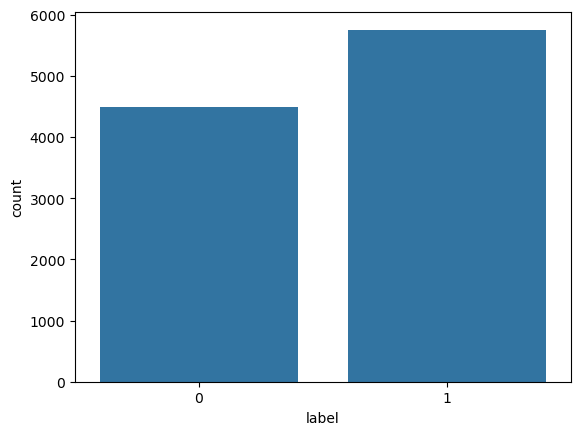

In [356]:
sns.countplot(x=df['label'])
print(df['label'].value_counts())

In [357]:
def extract_lexical_features(text):
    """
    Extracts lexical features from the text.
    """
    words = word_tokenize(text)
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    num_characters = len(text)
    num_sentences = len(list(nlp(text).sents))  # Count sentences
    return pd.Series([len(words), len(set(words)), avg_word_length, num_characters])

In [358]:
df[['word_count', 'unique_word_count', 'avg_word_length', 'char_count']] = df['statement'].apply(extract_lexical_features)
df.head()

,label,statement,barely-true_count,false_count,half-true_count,mostly-true_count,pants-fire_count,word_count,unique_word_count,avg_word_length,char_count
0,0,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0,12.0,12.0,6.000000,82.0
1,1,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0,28.0,27.0,4.214286,141.0
2,1,"Hillary Clinton agrees with John McCain ""by vo...",70.0,30.0,160.0,30.0,9.0,22.0,21.0,4.045455,105.0
3,0,Health care reform legislation is likely to ma...,7.0,19.0,3.0,5.0,10.0,13.0,13.0,5.153846,78.0
4,1,The economic turnaround started at the end of ...,15.0,9.0,20.0,19.0,2.0,11.0,11.0,4.090909,54.0


In [359]:
def extract_pos_features(text):
    doc = nlp(text)
    nouns = sum(1 for token in doc if token.pos_ == "NOUN")
    verbs = sum(1 for token in doc if token.pos_ == "VERB")
    prepositions = sum(1 for token in doc if token.pos_ == "ADP")
    sentences = len(list(doc.sents))
    return pd.Series([nouns, verbs, prepositions, sentences])

In [360]:
df[['nouns', 'verbs', 'prepositions', 'sentences']] = df['statement'].apply(extract_pos_features)
df.head()

,label,statement,barely-true_count,false_count,half-true_count,mostly-true_count,pants-fire_count,word_count,unique_word_count,avg_word_length,char_count,nouns,verbs,prepositions,sentences
0,0,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0,12.0,12.0,6.000000,82.0,4,2,1,1
1,1,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0,28.0,27.0,4.214286,141.0,5,5,3,2
2,1,"Hillary Clinton agrees with John McCain ""by vo...",70.0,30.0,160.0,30.0,9.0,22.0,21.0,4.045455,105.0,2,3,4,1
3,0,Health care reform legislation is likely to ma...,7.0,19.0,3.0,5.0,10.0,13.0,13.0,5.153846,78.0,7,1,0,1
4,1,The economic turnaround started at the end of ...,15.0,9.0,20.0,19.0,2.0,11.0,11.0,4.090909,54.0,3,1,2,1


In [361]:
from textblob import TextBlob

def extract_sentiment_features(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return pd.Series([polarity, subjectivity])

In [362]:
# df[['polarity', 'subjectivity']] = df['statement'].apply(extract_sentiment_features)
# df.head()

In [363]:
# Text Preprocessing
nltk.download('stopwords')
nltk.download('punkt')
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [364]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['statement'] = df['statement'].apply(preprocess_text)

df.head(10)

,label,statement,barely-true_count,false_count,half-true_count,mostly-true_count,pants-fire_count,word_count,unique_word_count,avg_word_length,char_count,nouns,verbs,prepositions,sentences
0,0,say anni list polit group support third trimes...,0.0,1.0,0.0,0.0,0.0,12.0,12.0,6.000000,82.0,4,2,1,1
1,1,declin coal start start natur ga took start be...,0.0,0.0,1.0,1.0,0.0,28.0,27.0,4.214286,141.0,5,5,3,2
2,1,hillari clinton agre john mccain vote give geo...,70.0,30.0,160.0,30.0,9.0,22.0,21.0,4.045455,105.0,2,3,4,1
3,0,health care reform legisl like mandat free sex...,7.0,19.0,3.0,5.0,10.0,13.0,13.0,5.153846,78.0,7,1,0,1
4,1,econom turnaround start end term,15.0,9.0,20.0,19.0,2.0,11.0,11.0,4.090909,54.0,3,1,2,1
5,1,chicago bear start quarterback last 10 year to...,0.0,3.0,2.0,5.0,1.0,30.0,27.0,4.300000,155.0,6,2,3,1
6,0,jim dunnam live district repres year,3.0,1.0,1.0,3.0,1.0,14.0,14.0,4.071429,69.0,2,2,2,1
7,1,person stage work activ last year pass along r...,70.0,30.0,160.0,30.0,9.0,31.0,29.0,4.290323,159.0,5,2,4,1
8,1,howev took 19 5 million oregon lotteri fund po...,0.0,0.0,1.0,0.0,1.0,26.0,25.0,4.692308,144.0,1,2,3,1
9,1,say gop primari oppon glenn grothman joe leibh...,0.0,0.0,0.0,1.0,0.0,23.0,23.0,4.869565,132.0,5,3,1,1


In [365]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))  # Extract unigram and bigram features
X_tfidf = vectorizer.fit_transform(df['statement'])

In [366]:
X_tfidf

<10238x77576 sparse matrix of type '<class 'numpy.float64'>'
	with 211537 stored elements in Compressed Sparse Row format>

In [367]:

pos_features_sparse = csr_matrix(df[['barely-true_count', 'false_count', 'half-true_count', 'mostly-true_count', 'pants-fire_count', 'nouns', 'verbs', 'prepositions', 'sentences','word_count', 'unique_word_count', 'avg_word_length', 'char_count']].values)


In [368]:
pos_features_sparse

<10238x13 sparse matrix of type '<class 'numpy.float64'>'
	with 115178 stored elements in Compressed Sparse Row format>

In [369]:
X = hstack([X_tfidf, pos_features_sparse])
X

<10238x77589 sparse matrix of type '<class 'numpy.float64'>'
	with 326715 stored elements in Compressed Sparse Row format>

In [370]:
Y = df["label"]
Y

0        0
1        1
2        1
3        0
4        1
        ..
10235    1
10236    1
10237    1
10238    0
10239    0
Name: label, Length: 10238, dtype: int64

In [371]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.30, random_state=42)

In [372]:
X_train

<7166x77589 sparse matrix of type '<class 'numpy.float64'>'
	with 228421 stored elements in Compressed Sparse Row format>

In [373]:
y_train

3483    1
3616    1
1443    1
9109    0
214     0
       ..
5735    1
5192    1
5391    1
860     0
7271    0
Name: label, Length: 7166, dtype: int64

In [374]:
y_test

5205    1
7753    0
4413    1
7208    1
4741    0
       ..
1533    1
2987    0
5624    1
1332    0
5509    0
Name: label, Length: 3072, dtype: int64

In [375]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n")
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print("---------------------------------------------------")

Accuracy: 0.7076822916666666
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.53      0.60      1297
           1       0.71      0.84      0.77      1775

    accuracy                           0.71      3072
   macro avg       0.71      0.68      0.69      3072
weighted avg       0.71      0.71      0.70      3072

Confusion Matrix:



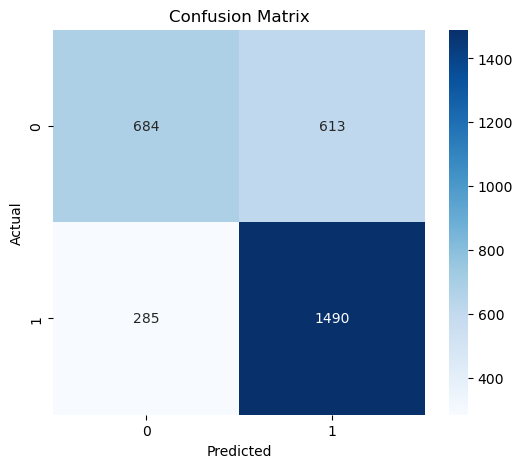

---------------------------------------------------


In [376]:
rf_model = RandomForestClassifier()
train_and_evaluate(rf_model, X_train, X_test, y_train, y_test)

Accuracy: 0.6139322916666666
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.12      0.21      1297
           1       0.60      0.97      0.74      1775

    accuracy                           0.61      3072
   macro avg       0.69      0.55      0.48      3072
weighted avg       0.67      0.61      0.52      3072

Confusion Matrix:



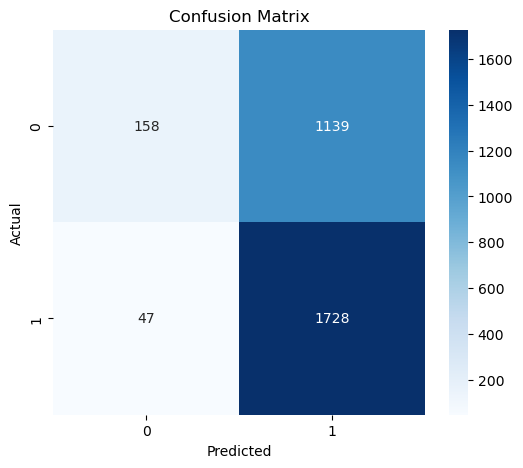

---------------------------------------------------


In [377]:
nb_model = MultinomialNB()
train_and_evaluate(nb_model, X_train, X_test, y_train, y_test)

Accuracy: 0.6158854166666666
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.51      0.53      1297
           1       0.66      0.69      0.67      1775

    accuracy                           0.62      3072
   macro avg       0.60      0.60      0.60      3072
weighted avg       0.61      0.62      0.61      3072

Confusion Matrix:



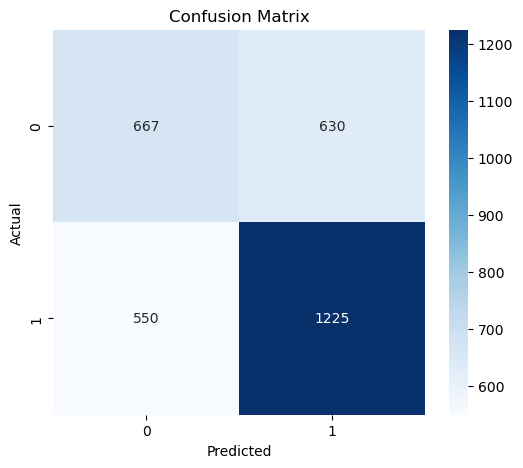

---------------------------------------------------


In [378]:
knn_model = KNeighborsClassifier()
train_and_evaluate(knn_model, X_train, X_test, y_train, y_test)

Accuracy: 0.6917317708333334
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.64      0.64      1297
           1       0.74      0.73      0.73      1775

    accuracy                           0.69      3072
   macro avg       0.68      0.68      0.68      3072
weighted avg       0.69      0.69      0.69      3072

Confusion Matrix:



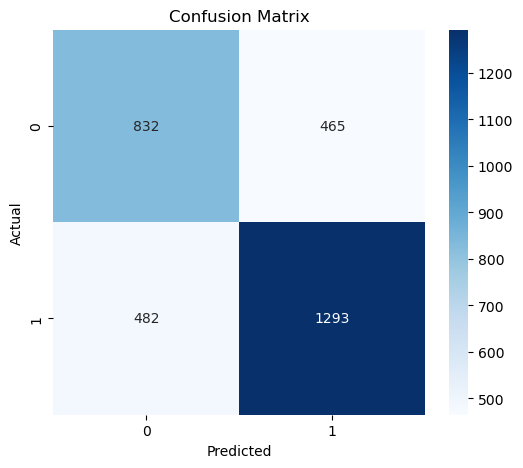

---------------------------------------------------


In [379]:
dt_model = DecisionTreeClassifier()
train_and_evaluate(dt_model, X_train, X_test, y_train, y_test)

Accuracy: 0.6438802083333334
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.49      0.54      1297
           1       0.67      0.76      0.71      1775

    accuracy                           0.64      3072
   macro avg       0.63      0.62      0.62      3072
weighted avg       0.64      0.64      0.64      3072

Confusion Matrix:



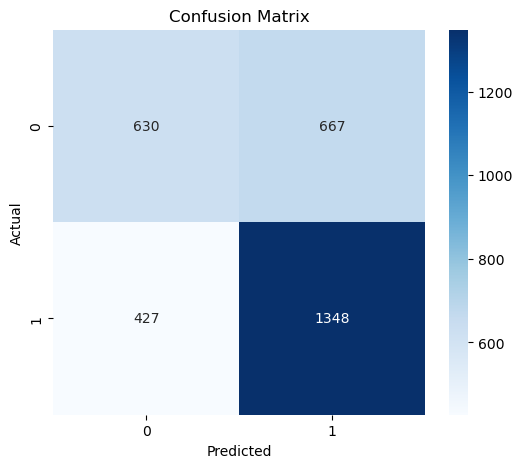

---------------------------------------------------


In [380]:
svm_model = SVC(kernel="linear")
train_and_evaluate(svm_model, X_train, X_test, y_train, y_test)

Accuracy: 0.7333984375
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.66      0.68      1297
           1       0.76      0.79      0.77      1775

    accuracy                           0.73      3072
   macro avg       0.73      0.72      0.72      3072
weighted avg       0.73      0.73      0.73      3072

Confusion Matrix:



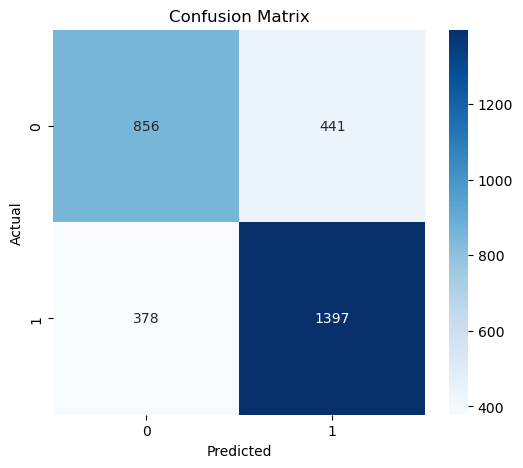

---------------------------------------------------


In [381]:
xgb_model = xgb.XGBClassifier()
train_and_evaluate(xgb_model, X_train, X_test, y_train, y_test)

In [382]:
from sklearn.model_selection import RandomizedSearchCV


--- Tuning SVC (Randomized Search) ---
Fitting RandomizedSearchCV for SVC...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
SVC fitting complete.

Best SVC Parameters Found (Randomized Search):
{'kernel': 'rbf', 'gamma': 'scale', 'C': 100}

--- Evaluating Best SVC Model ---
Accuracy: 0.6393229166666666
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.36      0.45      1297
           1       0.64      0.85      0.73      1775

    accuracy                           0.64      3072
   macro avg       0.64      0.60      0.59      3072
weighted avg       0.64      0.64      0.61      3072

Confusion Matrix:



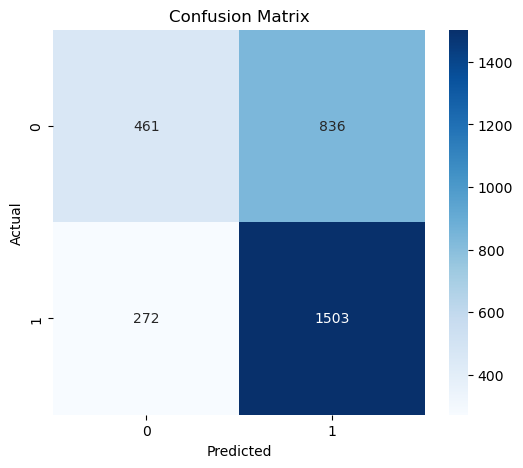

---------------------------------------------------
--- Tuning XGBoost (Randomized Search) ---
Fitting RandomizedSearchCV for XGBoost...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
XGBoost fitting complete.

Best XGBoost Parameters Found (Randomized Search):
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

--- Evaluating Best XGBoost Model ---
Accuracy: 0.7386067708333334
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.65      0.68      1297
           1       0.76      0.80      0.78      1775

    accuracy                           0.74      3072
   macro avg       0.73      0.73      0.73      3072
weighted avg       0.74      0.74      0.74      3072

Confusion Matrix:



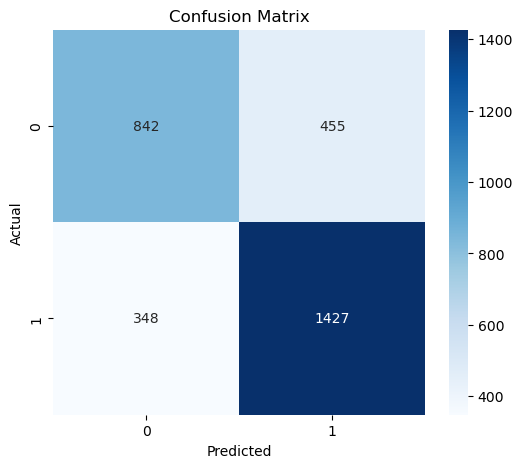

---------------------------------------------------


In [383]:
# --- Define Parameter Grids (keep these from before) ---

# For SVC
svc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

# For XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [ 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}


# --- Tuning and Evaluating SVC with RandomizedSearchCV ---

print("--- Tuning SVC (Randomized Search) ---")
# Instantiate the base SVC model
svc_base = SVC(probability=True) # probability=True can be useful but might slow down SVC slightly, remove if not needed

# Instantiate RandomizedSearchCV
# n_iter=15 means try 15 random parameter combinations
# cv=2 means 2-fold cross-validation
random_search_svc = RandomizedSearchCV(
    estimator=svc_base,
    param_distributions=svc_param_grid, # Use param_distributions
    n_iter=4,          # <<< Number of parameter settings that are sampled
    cv=2,               # <<< Reduced CV folds
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42     # <<< For reproducible results
)

# Fit RandomizedSearchCV to the training data
# Ensure X_train, y_train are defined and contain your training data
print("Fitting RandomizedSearchCV for SVC...")
random_search_svc.fit(X_train, y_train)
print("SVC fitting complete.")

# Get the best model found
best_svc = random_search_svc.best_estimator_

# Print the best parameters found
print("\nBest SVC Parameters Found (Randomized Search):")
print(random_search_svc.best_params_)

# Evaluate the *best* SVC model on the test set
print("\n--- Evaluating Best SVC Model ---")
# Ensure X_test, y_test are defined and contain your test data
y_pred_svc = best_svc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred_svc)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print("---------------------------------------------------")


# --- Tuning and Evaluating XGBoost with RandomizedSearchCV ---

print("--- Tuning XGBoost (Randomized Search) ---")
# Instantiate the base XGBoost model
xgb_base = xgb.XGBClassifier(eval_metric='mlogloss' if len(np.unique(y_train)) > 2 else 'logloss')

# Instantiate RandomizedSearchCV
# n_iter=20 means try 20 random parameter combinations
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid, # Use param_distributions
    n_iter=4,          # <<< Number of parameter settings that are sampled
    cv=2,               # <<< Reduced CV folds
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42     # <<< For reproducible results
)

# Fit RandomizedSearchCV to the training data
print("Fitting RandomizedSearchCV for XGBoost...")
random_search_xgb.fit(X_train, y_train)
print("XGBoost fitting complete.")

# Get the best model found
best_xgb = random_search_xgb.best_estimator_

# Print the best parameters found
print("\nBest XGBoost Parameters Found (Randomized Search):")
print(random_search_xgb.best_params_)

# Evaluate the *best* XGBoost model on the test set
print("\n--- Evaluating Best XGBoost Model ---")
y_pred_xgb = best_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print("---------------------------------------------------")

In [384]:
y_scores = best_xgb.predict_proba(X_test)[:, 1]

In [385]:
from sklearn.metrics import roc_auc_score, roc_curve

In [386]:
auc_score = roc_auc_score(y_test, y_scores)
print(f"ROC AUC Score: {auc_score:.2f}")

ROC AUC Score: 0.82


In [387]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

['00' '00 2014' '00 spent' ... 'zuckerberg' 'zuckerberg less'
 'zuckerberg person']


In [388]:

tfidf_feature_names = list(feature_names);
other_feature_names = ['barely-true_count', 'false_count', 'half-true_count', 'mostly-true_count', 'pants-fire_count', 'nouns', 'verbs', 'prepositions', 'sentences','word_count', 'unique_word_count', 'avg_word_length', 'char_count', 'polarity', 'subjectivity']
all_feature_names = tfidf_feature_names + other_feature_names


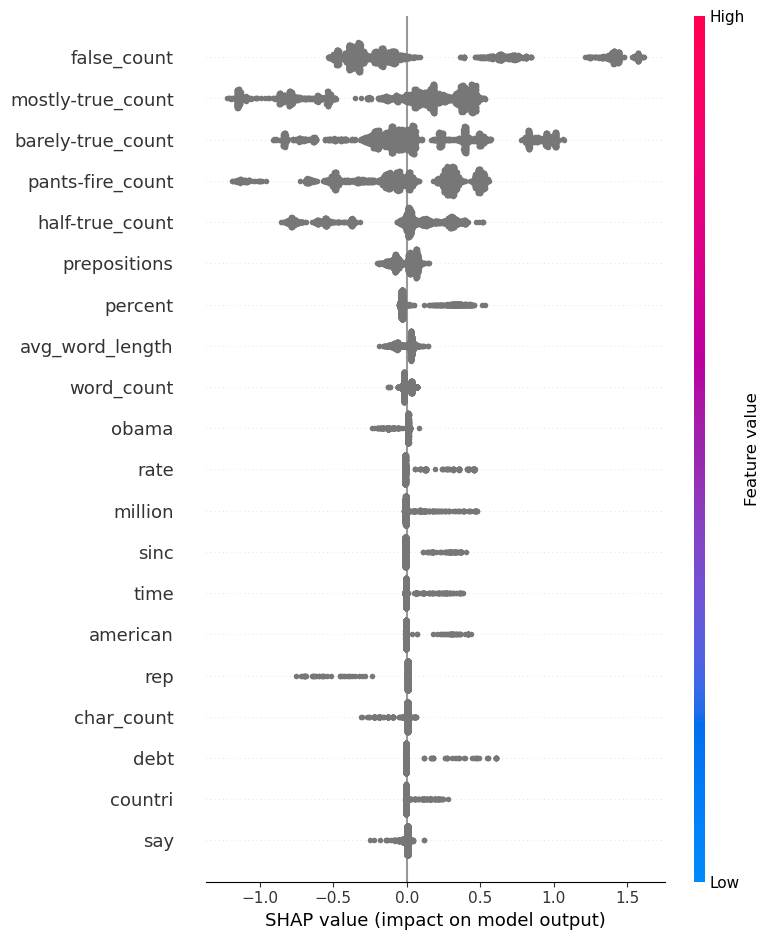

In [389]:
import shap
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=all_feature_names)